In [1]:
# %%bash
# pip install lightfm

In [2]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn import model_selection
from scipy.sparse import coo_matrix
from time import time
import matplotlib.pyplot as plt
import csv

import numpy as np
import pandas as pd

# from google.colab import files

/Users/joshfeldman/Desktop/Projects/personalization_project/venv/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Util

In [4]:
def downloadCSVFile(listOfDicts, fileName):
    resultDF = pd.DataFrame(listOfDicts)
    resultDF.to_csv(fileName)
#   files.download(fileName)

##Get Data

In [ ]:
# %%bash
# mkdir -p 'results'

# rm ratings.csv

In [ ]:
# # Upload ratings.csv

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

### Make Train, Validate, Test

In [5]:
# ratingsDataPath = 'ratings_5550689.csv'
ratingsDataPath = 'data-medium/ratings_1387672.csv'

ratingsDF = pd.read_csv(ratingsDataPath)
ratingsDF = ratingsDF[['userId', 'movieId', 'rating']]

print('We have {} ratings total'.format(len(ratingsDF)))

# Alter ratings to work better for our model
ratingsDF['rating'] = ratingsDF['rating'].apply(lambda x: x - 2.9)

userIds = ratingsDF['userId'].unique().astype('int32')
movieIds = ratingsDF['movieId'].unique().astype('int32')

print('We have {} users'.format(len(userIds)))
print('We have {} movies'.format(len(movieIds)))

movieIdToIndex = {}
for index, movieId in enumerate(movieIds):
    movieIdToIndex[movieId] = index

userIdToIndex = {}
for index, userId in enumerate(userIds):
    userIdToIndex[userId] = index

ratingsTrainDF, ratingsTestDF = model_selection.train_test_split(ratingsDF, test_size=0.2, random_state=324)
ratingsTrainGridSearchDF, ratingsValidateGridSearchDF = model_selection.train_test_split(ratingsTrainDF, test_size=0.2, random_state=773)

print('We have {} train ratings'.format(len(ratingsTrainDF)))
print('We have {} test ratings'.format(len(ratingsTestDF)))
print('We have {} grid search train ratings'.format(len(ratingsTrainGridSearchDF)))
print('We have {} grid search validate ratings'.format(len(ratingsValidateGridSearchDF)))


We have 1387672 ratings total
We have 203750 users
We have 24174 movies
We have 1110137 train ratings
We have 277535 test ratings
We have 888109 grid search train ratings
We have 222028 grid search validate ratings


In [6]:
ratingsTrainDF.head()

,userId,movieId,rating
1385920,258790,594,-0.4
18532,211231,2797,-0.4
784929,198557,356,1.1
812525,266597,166486,0.1
608720,191893,434,1.1


### Convert to Matrix

In [7]:
def ratingsDFToUserMovieMatrix(ratingsDF, userIdToIndex, movieIdToIndex):
    numUsers = len(userIdToIndex)
    numMovies = len(movieIdToIndex)

    userMovieMatrix = np.zeros((numUsers, numMovies))

    for index, row in ratingsDF.iterrows():
        userId = int(row['userId'])
        movieId = int(row['movieId'])
        rating = int(row['rating'])

        userIndex = userIdToIndex[userId]
        movieIndex = movieIdToIndex[movieId]
        userMovieMatrix[userIndex, movieIndex] = rating


    return coo_matrix(userMovieMatrix)


XTrain = ratingsDFToUserMovieMatrix(ratingsTrainGridSearchDF, userIdToIndex, movieIdToIndex)
XValidate = ratingsDFToUserMovieMatrix(ratingsValidateGridSearchDF, userIdToIndex, movieIdToIndex)
XTest = ratingsDFToUserMovieMatrix(ratingsTestDF, userIdToIndex, movieIdToIndex)

In [8]:
print('Shape of X Train: {}'.format(XTrain.shape))
print('Shape of X Validate: {}'.format(XValidate.shape))
print('Shape of X Test: {}'.format(XTest.shape))

Shape of X Train: (203750, 24174)
Shape of X Validate: (203750, 24174)
Shape of X Test: (203750, 24174)


# Add K-Fold Validation to Grid Search

# Run Grid Search

In [9]:
def runModel(params, XTrain, XTest):
    learningRate = params['learning_rate']
    lossFunction = params['loss']
    learning_schedule = params['learning_schedule']
  
    startTime = time()
  
    model = LightFM(
        learning_rate=learningRate, 
        loss=lossFunction, 
        learning_schedule=learning_schedule, 
        random_state=8362
    )
    model.fit(XTrain, epochs=5)

    totalTime = time() - startTime

    # Evaluate the trained model
    #   test_precision = precision_at_k(model, XTest, k=10).mean()
    #   test_recall = recall_at_k(model, XTest, k=10).mean()
    train_auc = auc_score(model, XTrain).mean()
    test_auc = auc_score(model, XTest).mean()

    return train_auc, test_auc, totalTime

In [10]:
gridSearchParams = {
    'learning_rate': [0.05],
    'loss': ['logistic', 'bpr', 'warp', 'warp-kos'],
#     'loss': ['bpr'],
    'learning_schedule': ['adagrad', 'adadelta'],
}

def gridSearch(gridSearchParams):
  
    results = []
  
    for learningRate in gridSearchParams['learning_rate']:
        for lossFunction in gridSearchParams['loss']:
            for learning_schedule in gridSearchParams['learning_schedule']:
                params = {
                    'learning_rate': learningRate,
                    'loss': lossFunction,
                    'learning_schedule': learning_schedule,
                }
                train_auc, test_auc, totalTime = runModel(params, XTrain, XValidate)
                params['train_auc'] = train_auc
                params['test_auc'] = test_auc
                params['time'] = totalTime
                results.append(params)
        
    print(results)
    downloadCSVFile(results, 'gridSearchResults.csv')
    return results

In [11]:
startTime = time()

gridSearchResults = gridSearch(gridSearchParams)

totalTime = time() - startTime
if totalTime > 60:
    print('Total time: {:0.2f} minutes'.format(totalTime / 60))
else:
    print('Total time: {:0.2f} seconds'.format(totalTime))

[{'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adagrad', 'train_auc': 0.9219905, 'test_auc': 0.9139257, 'time': 1.6321492195129395}, {'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adadelta', 'train_auc': 0.9279596, 'test_auc': 0.9189989, 'time': 1.8815410137176514}, {'learning_rate': 0.05, 'loss': 'bpr', 'learning_schedule': 'adagrad', 'train_auc': 0.78119415, 'test_auc': 0.7568181, 'time': 2.107844829559326}, {'learning_rate': 0.05, 'loss': 'bpr', 'learning_schedule': 'adadelta', 'train_auc': 0.84351707, 'test_auc': 0.6305863, 'time': 2.6683709621429443}, {'learning_rate': 0.05, 'loss': 'warp', 'learning_schedule': 'adagrad', 'train_auc': 0.97218096, 'test_auc': 0.94685006, 'time': 2.290062189102173}, {'learning_rate': 0.05, 'loss': 'warp', 'learning_schedule': 'adadelta', 'train_auc': 0.96112394, 'test_auc': 0.94977796, 'time': 2.7585699558258057}, {'learning_rate': 0.05, 'loss': 'warp-kos', 'learning_schedule': 'adagrad', 'train_auc': 0.9795900

In [12]:
def extractBestParams(gridSearchResults):
    bestIndex = 0
    bestAUC = gridSearchResults[0]['test_auc']

    for index, results in enumerate(gridSearchResults):
    if results['test_auc'] > bestAUC:
        bestAUC = results['test_auc']
        bestIndex = index

    bestParams = {}
    for param, value in gridSearchResults[bestIndex].items():
    if param in ['train_auc', 'test_auc', 'time']:
        continue

    bestParams[param] = value

    print('Best AUC is: {}'.format(bestAUC))
    return bestParams

bestParams = extractBestParams(gridSearchResults)
bestParams

Best AUC is: 0.9497779607772827


{'learning_rate': 0.05, 'learning_schedule': 'adadelta', 'loss': 'warp'}

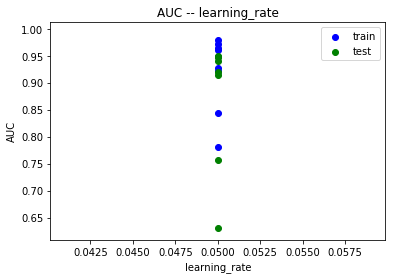

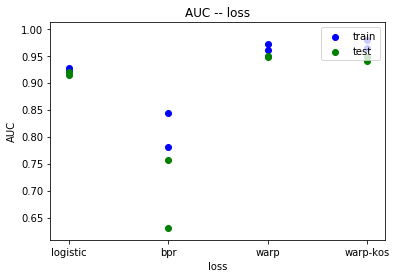

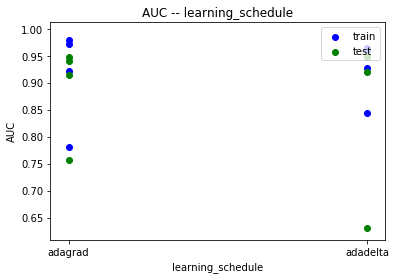

In [13]:
def plotGridSearchResults(gridSearchResults):
    gridSearchDF = pd.DataFrame(gridSearchResults)
    for param in gridSearchParams.keys():
        plt.scatter(gridSearchDF[param], gridSearchDF['train_auc'], color='blue')
        plt.scatter(gridSearchDF[param], gridSearchDF['test_auc'], color='green')
        plt.title('AUC -- {}'.format(param))
        plt.ylabel('AUC')
        plt.xlabel(param)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

plotGridSearchResults(gridSearchResults)

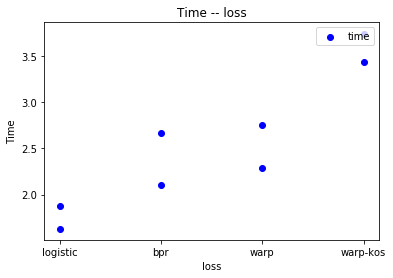

In [16]:
def plotGridSearchTime(gridSearchResults):
    gridSearchDF = pd.DataFrame(gridSearchResults)
    plt.scatter(gridSearchDF['loss'], gridSearchDF['time'], color='blue')
    plt.title('Time -- {}'.format('loss'))
    plt.ylabel('Time')
    plt.xlabel('loss')
    plt.legend(['time'], loc='upper right')
    plt.show()

plotGridSearchTime(gridSearchResults)

# Find Best # of Epochs

# Sampling Amount of Data

In [17]:
dataFractions = np.arange(0.2, 1.2, 0.2)
numRatings = len(ratingsTrainDF)
dataSizes = [int(fraction * numRatings) for fraction in dataFractions]
dataSizes

[111013,
 222027,
 333041,
 444054,
 555068,
 666082,
 777095,
 888109,
 999123,
 1110137]

In [18]:
def sizeSamplingSearch(dataSizes):
    sizeSamplingResults = []

    for numRatings in dataSizes:
        print('Running for size: {}'.format(numRatings))
        ratingsTrainDFSampled = ratingsTrainDF.sample(n=numRatings)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndex)
        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XValidate)
        result = {
            'numRatings': numRatings,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        sizeSamplingResults.append(result)

    return sizeSamplingResults

In [19]:
sizeSamplingResults = sizeSamplingSearch(dataSizes)


Running for size: 111013
Running for size: 222027
Running for size: 333041
Running for size: 444054
Running for size: 555068
Running for size: 666082
Running for size: 777095
Running for size: 888109
Running for size: 999123
Running for size: 1110137


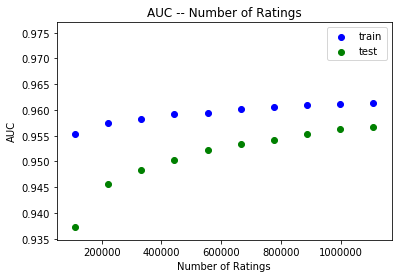

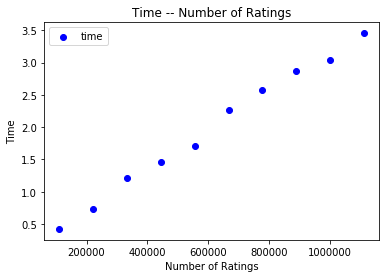

In [34]:
def plotSizeSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Ratings')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Ratings')
    plt.legend(['time'], loc='upper left')
    plt.show()

plotSizeSamplingResults(sizeSamplingResults)

# Sample By Number of Users

In [21]:
userFractions = np.arange(0.2, 1.2, 0.2)
numUsers = len(userIds)
userSizes = [int(fraction * numUsers) for fraction in userFractions]
userSizes

[40750, 81500, 122250, 163000, 203750]

In [22]:
def userSamplingSearch(userSizes):
    userSamplingResults = []

    for numUsers in userSizes:
        print('Running for size: {}'.format(numUsers))
        sampledUserIds = np.random.choice(userIds, numUsers, replace=False)
        userIdToIndexSampled = {}
        for index, userId in enumerate(sampledUserIds):
            userIdToIndexSampled[userId] = index

        ratingsDFSampled = ratingsDF[ratingsDF['userId'].isin(sampledUserIds)]

        ratingsTrainDFSampled, ratingsTestDFSampled = model_selection.train_test_split(ratingsDFSampled, test_size=0.2, random_state=3339)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndexSampled, movieIdToIndex)
        XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndexSampled, movieIdToIndex)

        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest)
        result = {
            'numUsers': numUsers,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        userSamplingResults.append(result)

    return userSamplingResults

In [23]:
userSamplingResults = userSamplingSearch(userSizes)
userSamplingResults

Running for size: 40750
Running for size: 81500
Running for size: 122250
Running for size: 163000
Running for size: 203750


[{'numUsers': 40750,
  'test_auc': 0.9426322,
  'time': 0.6371409893035889,
  'train_auc': 0.96098465},
 {'numUsers': 81500,
  'test_auc': 0.9465188,
  'time': 1.327388048171997,
  'train_auc': 0.96152043},
 {'numUsers': 122250,
  'test_auc': 0.9505158,
  'time': 2.2145321369171143,
  'train_auc': 0.96156293},
 {'numUsers': 163000,
  'test_auc': 0.9506204,
  'time': 3.2931840419769287,
  'train_auc': 0.9615148},
 {'numUsers': 203750,
  'test_auc': 0.951604,
  'time': 3.744964122772217,
  'train_auc': 0.96135646}]

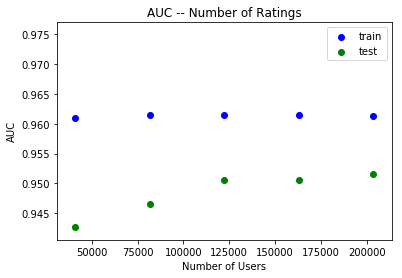

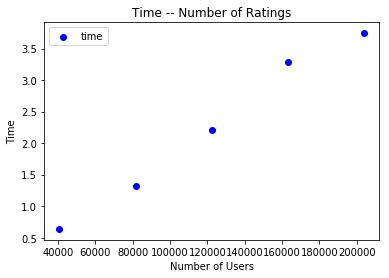

In [35]:
def plotUserSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Users')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Users')
    plt.legend( ['time'], loc='upper left')
    plt.show()

plotUserSamplingResults(userSamplingResults)

# Sample By Number of Movies

In [25]:
movieFractions = np.arange(0.2, 1.2, 0.2)
numMovies = len(movieIds)
movieSizes = [int(fraction * numMovies) for fraction in movieFractions]
movieSizes

[4834, 9669, 14504, 19339, 24174]

In [28]:
def movieSamplingSearch(movieSizes):
    movieSamplingResults = []

    for numMovies in movieSizes:
        print('Running for size: {}'.format(numMovies))
        sampledMovieIds = np.random.choice(movieIds, numMovies, replace=False)
        movieIdToIndexSampled = {}
        for index, movieId in enumerate(sampledMovieIds):
            movieIdToIndexSampled[movieId] = index

        ratingsDFSampled = ratingsDF[ratingsDF['movieId'].isin(sampledMovieIds)]

        ratingsTrainDFSampled, ratingsTestDFSampled = model_selection.train_test_split(ratingsDFSampled, test_size=0.2, random_state=3339)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndexSampled)
        XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndex, movieIdToIndexSampled)

        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest)
        result = {
            'numMovie': numMovies,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        movieSamplingResults.append(result)

    return movieSamplingResults

In [29]:
movieSamplingResults = movieSamplingSearch(movieSizes)
movieSamplingResults

Running for size: 4834
Running for size: 9669
Running for size: 14504
Running for size: 19339
Running for size: 24174


[{'numMovie': 4834,
  'test_auc': 0.94238263,
  'time': 0.6814761161804199,
  'train_auc': 0.95444995},
 {'numMovie': 9669,
  'test_auc': 0.94631886,
  'time': 1.263667345046997,
  'train_auc': 0.95836145},
 {'numMovie': 14504,
  'test_auc': 0.9497951,
  'time': 1.961143970489502,
  'train_auc': 0.9609808},
 {'numMovie': 19339,
  'test_auc': 0.95028424,
  'time': 3.1878890991210938,
  'train_auc': 0.9607884},
 {'numMovie': 24174,
  'test_auc': 0.95169675,
  'time': 4.012967109680176,
  'train_auc': 0.9614144}]

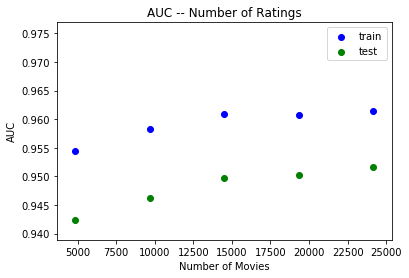

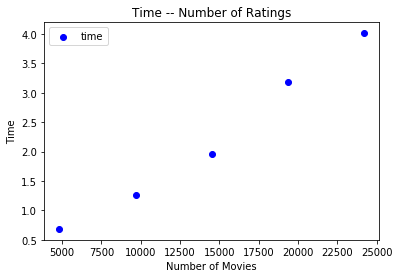

In [36]:
def plotMovieSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Movies')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Movies')
    plt.legend( ['time'], loc='upper left')
    plt.show()

plotMovieSamplingResults(movieSamplingResults)